In [3]:
!pip install keras-cv

  Using cached regex-2025.11.3-cp312-cp312-win_amd64.whl.metadata (41 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached pyarrow-22.0.0-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached zipp-3.23.0-py3-none-any.whl.metadata (3.6 kB)
  Using cached attrs-25.4.0-py3-none-any.whl.metadata (10 kB)
   ---------------------------------------- 0.0/650.7 kB ? eta -:--:--
   ---------------------------------------- 650.7/650.7 kB 5.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/950.8 kB ? eta -:--:--
   --------------------------------------- 950.8/950.8 kB 22.2 MB/s eta 0:00:00
Using cached regex-2025.11.3-cp312-cp312-win_amd64.whl (277 kB)
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ---------------------------------------- 5.3/5.3 MB 40.5 MB/s


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf

# Standard Keras Imports
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1  # Or whichever version you need

# REPLACEMENT for vit_keras (Vision Transformers)
# KerasCV is the modern standard for Python 3.11+
import keras_cv 

# Metrics and Sklearn
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight

# Set Seeds for Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow Version: {tf.__version__}")
print(f"KerasCV Version: {keras_cv.__version__}")

TensorFlow Version: 2.20.0
KerasCV Version: 0.9.0


In [20]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
NUM_CLASSES = 10
# Notebook runs from the `notebooks/` folder, so use ../data/...
DATA_PATH = "../data/Augmented_images"
CLASS_NAMES = [
    'Central_Serous_Chorioretinopathy',
    'Diabetic_Retinopathy',
    'Disc_Edema',
    'Glaucoma',
    'Healthy',
    'Macular_Scar',
    'Myopia',
    'Pterygium',
    'Retinal_Detachment',
    'Retinitis_Pigmentosa'
]

In [21]:
class_counts = {}

for cls in CLASS_NAMES:
    cls_path = os.path.join(DATA_PATH, cls)
    class_counts[cls] = len(os.listdir(cls_path))
class_counts

{'Central_Serous_Chorioretinopathy': 606,
 'Diabetic_Retinopathy': 3444,
 'Disc_Edema': 762,
 'Glaucoma': 2880,
 'Healthy': 2676,
 'Macular_Scar': 1937,
 'Myopia': 2251,
 'Pterygium': 102,
 'Retinal_Detachment': 750,
 'Retinitis_Pigmentosa': 834}

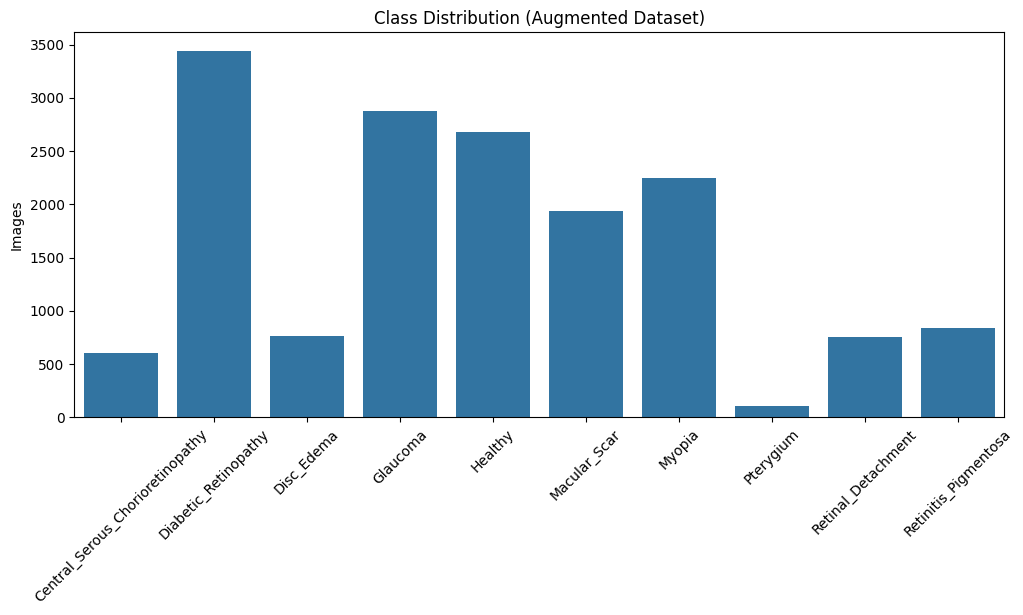

In [22]:
plt.figure(figsize=(12,5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=45)
plt.title("Class Distribution (Augmented Dataset)")
plt.ylabel("Images")
plt.show()

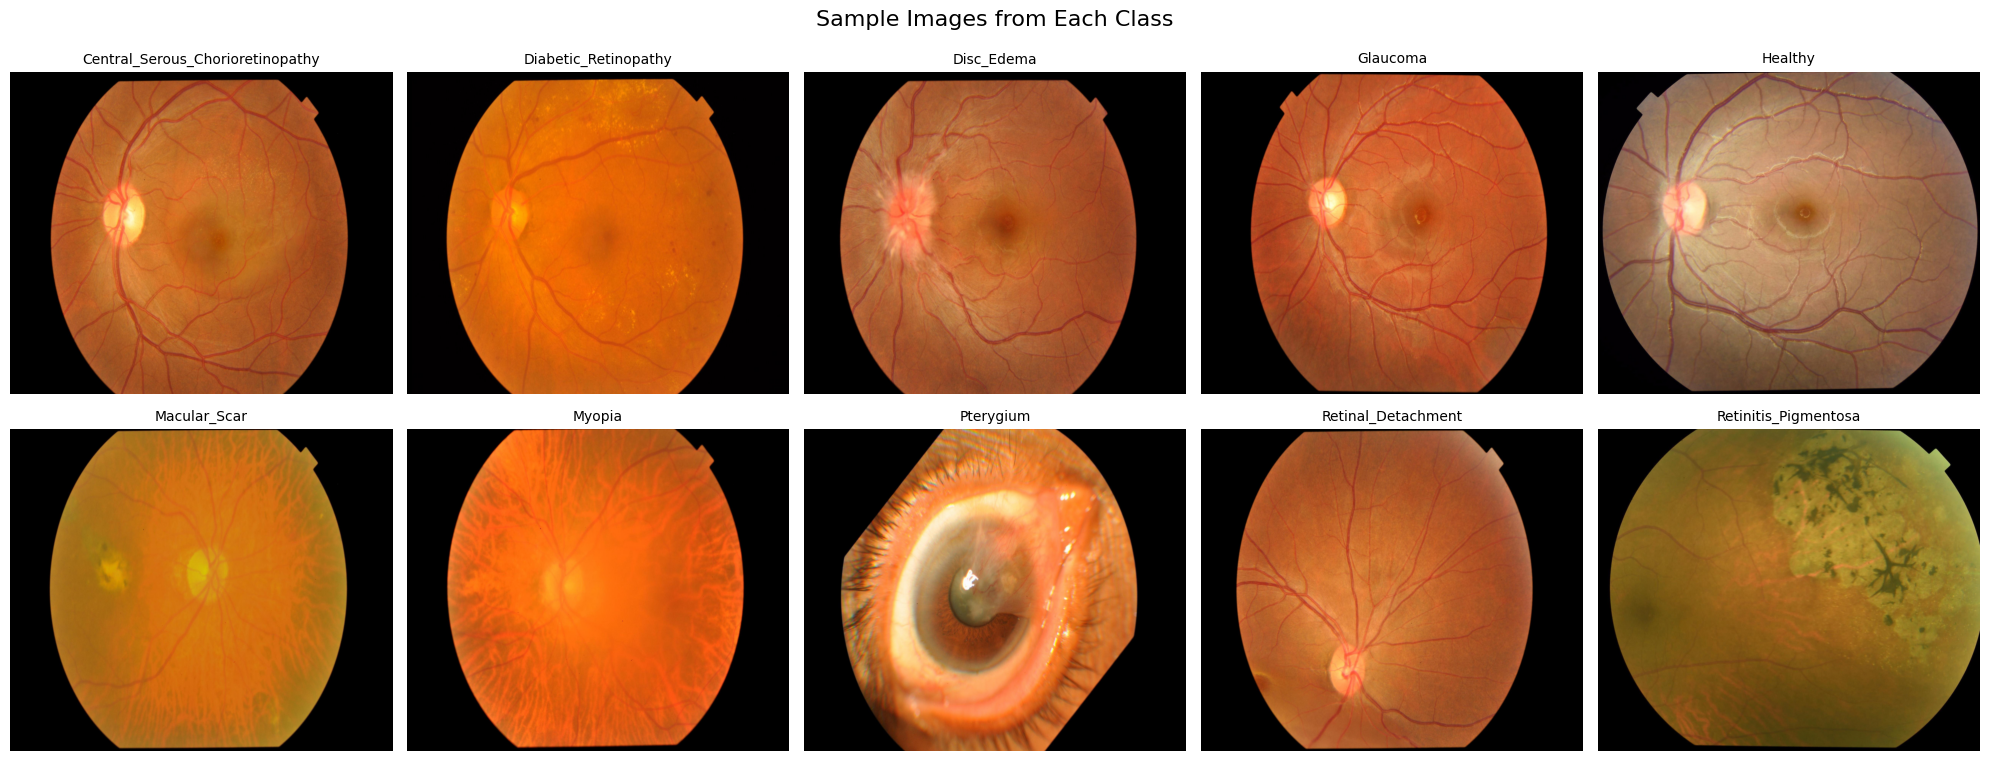

In [23]:
from PIL import Image

def display_sample_images():
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()

    for idx, class_name in enumerate(CLASS_NAMES):
        class_path = os.path.join(DATA_PATH, class_name)
        images = os.listdir(class_path)
        img_name = random.choice(images)
        img_path = os.path.join(class_path, img_name)

        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(class_name, fontsize=10)
        axes[idx].axis('off')

    plt.suptitle('Sample Images from Each Class', fontsize=16)
    plt.tight_layout()
    plt.show()

display_sample_images()

In [24]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

In [25]:
train_gen = datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

Found 12997 images belonging to 10 classes.


In [26]:
val_gen = datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

Found 3245 images belonging to 10 classes.


In [27]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(2.6797938144329896), 1: np.float64(0.471589259796807), 2: np.float64(2.130655737704918), 3: np.float64(0.5641059027777777), 4: np.float64(0.6070527790751985), 5: np.float64(0.838516129032258), 6: np.float64(0.7216546363131594), 7: np.float64(15.85), 8: np.float64(2.166166666666667), 9: np.float64(1.9456586826347306)}


In [28]:
def build_efficientnet():
    base = keras.applications.EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=(224,224,3)
    )
    base.trainable = False

    inputs = keras.Input(shape=(224,224,3))
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    return keras.Model(inputs, outputs)

In [29]:
cnn_model = build_efficientnet()

In [30]:
cnn_model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(multi_label=True)]
)
cnn_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385,197 (16.73 MB)

 Trainable params: 333,066 (1.27 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [31]:
history = cnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weights
)

Epoch 1/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 932s 2s/step - accuracy: 0.3769 - auc_1: 0.8227 - loss: 1.6429 - val_accuracy: 0.5852 - val_auc_1: 0.9173 - val_loss: 1.2192
Epoch 2/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 574s 1s/step - accuracy: 0.5475 - auc_1: 0.9091 - loss: 1.0435 - val_accuracy: 0.6357 - val_auc_1: 0.9319 - val_loss: 1.0498
Epoch 3/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 584s 1s/step - accuracy: 0.6038 - auc_1: 0.9286 - loss: 0.8916 - val_accuracy: 0.6589 - val_auc_1: 0.9368 - val_loss: 0.9943
Epoch 4/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 579s 1s/step - accuracy: 0.6334 - auc_1: 0.9390 - loss: 0.8067 - val_accuracy: 0.6706 - val_auc_1: 0.9409 - val_loss: 0.9595
Epoch 5/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 582s 1s/step - accuracy: 0.6608 - auc_1: 0.9477 - loss: 0.7284 - val_accuracy: 0.6844 - val_auc_1: 0.9431 - val_loss: 0.9385
Epoch 6/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 585s 1s/step - accuracy: 0.6811 - auc_1: 0.9526 - loss: 0.6836 - val_accuracy: 0.6872 - val_auc_1: 0.9428 - val_loss: 0.9354
Epoch 7/30

In [33]:
cnn_model.save('models/final_eye_disease_model.h5')
cnn_model.save('models/final_eye_disease_model.keras')

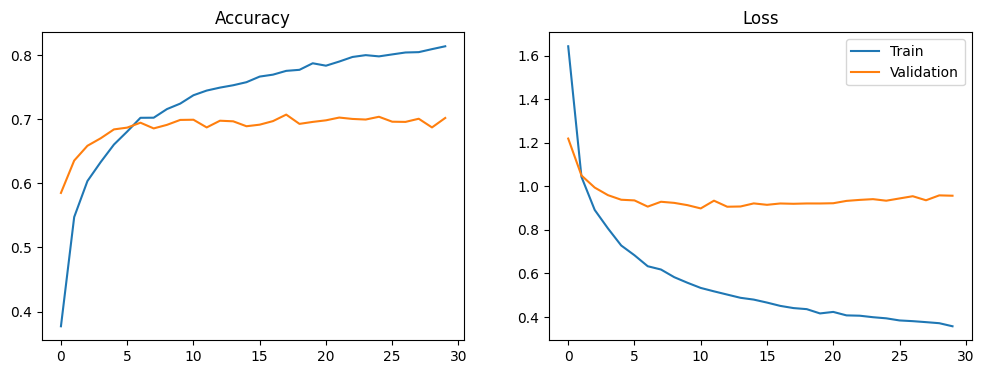

In [35]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.legend(["Train", "Validation"])

plt.show()

102/102 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step


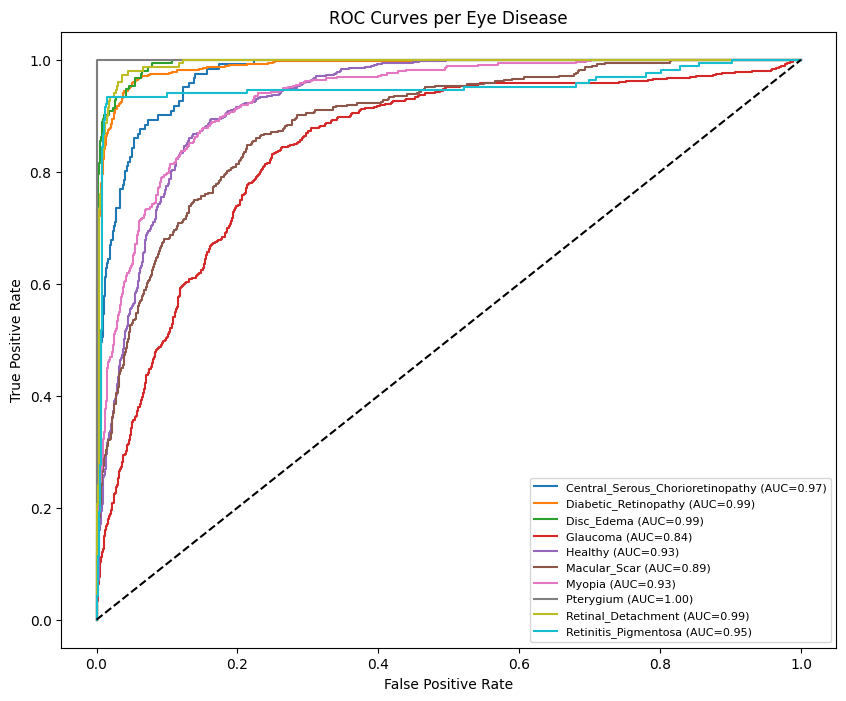

In [36]:
y_true = val_gen.classes
y_pred = cnn_model.predict(val_gen)

y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))

plt.figure(figsize=(10,8))

for i, cls in enumerate(CLASS_NAMES):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Eye Disease")
plt.legend(fontsize=8)
plt.show()

In [37]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

l2_reg = regularizers.l2(1e-4)

In [38]:
# 1) Get config and weights of the trained model
config = cnn_model.get_config()
weights = cnn_model.get_weights()

In [39]:
config

{'name': 'functional_1',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 224, 224, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_layer_3',
    'optional': False},
   'registered_name': None,
   'name': 'input_layer_3',
   'inbound_nodes': []},
  {'module': 'keras.src.models.functional',
   'class_name': 'Functional',
   'config': {'name': 'efficientnetb0',
    'trainable': False,
    'layers': [{'module': 'keras.layers',
      'class_name': 'InputLayer',
      'config': {'batch_shape': (None, 224, 224, 3),
       'dtype': 'float32',
       'sparse': False,
       'ragged': False,
       'name': 'input_layer_2',
       'optional': False},
      'registered_name': None,
      'name': 'input_layer_2',
      'inbound_nodes': []},
     {'module': 'keras.layers',
      'class_name': 'Rescaling',
      'config': {'name': 'rescaling_2',
       'trainable': False,
       'dty

In [40]:
weights

[array([0.485, 0.456, 0.406], dtype=float32),
 array([0.229, 0.224, 0.225], dtype=float32),
 np.int64(0),
 array([[[[ 2.07668245e-02,  8.53624821e-01, -9.72171009e-01,
            5.80005467e-01,  3.13335508e-02, -1.81043148e-02,
           -1.28635168e-02,  5.94060645e-02, -7.41896749e-01,
           -2.27897346e-01,  2.00766921e-01, -2.33019665e-02,
           -3.82314444e-01, -1.13366711e+00, -4.97356057e-02,
           -5.28575480e-01,  6.01686649e-02,  3.28413874e-01,
            7.26403654e-01,  9.56093222e-02,  2.53003836e-03,
            7.99428642e-01,  1.60467178e-01,  1.51992925e-02,
            2.15564728e-01, -6.15406692e-01,  7.56446272e-02,
            3.47692966e-02,  0.00000000e+00, -6.27994761e-02,
            2.23197415e-02, -1.42137900e-01],
          [ 1.28902495e-02,  1.56575632e+00, -1.80467033e+00,
            7.77730107e-01,  6.52952865e-02,  2.08790317e-01,
           -8.81190374e-02, -3.78276139e-01,  5.80090940e-01,
           -3.44047934e-01,  6.91463649e-0

In [41]:
# 2) Inject kernel_regularizer into Dense layers in the config
for layer_cfg in config["layers"]:
    if layer_cfg["class_name"] == "Dense":
        layer_cfg["config"]["kernel_regularizer"] = {
            "class_name": "L2",
            "config": {"l2": float(1e-4)},
        }

In [42]:
# 3) Rebuild model from modified config and load old weights
regularized_model = keras.Model.from_config(config)
regularized_model.set_weights(weights)

In [43]:
# 4) Recompile
regularized_model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(multi_label=True)],
)

In [44]:
# 5) Continue training with regularization active
history_reg = regularized_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    class_weight=class_weights,
)

Epoch 1/5
407/407 ━━━━━━━━━━━━━━━━━━━━ 645s 2s/step - accuracy: 0.7084 - auc_2: 0.9606 - loss: 0.6659 - val_accuracy: 0.6733 - val_auc_2: 0.9434 - val_loss: 1.0131
Epoch 2/5
407/407 ━━━━━━━━━━━━━━━━━━━━ 614s 2s/step - accuracy: 0.7286 - auc_2: 0.9678 - loss: 0.5887 - val_accuracy: 0.6724 - val_auc_2: 0.9438 - val_loss: 1.0180
Epoch 3/5
407/407 ━━━━━━━━━━━━━━━━━━━━ 615s 2s/step - accuracy: 0.7407 - auc_2: 0.9688 - loss: 0.5750 - val_accuracy: 0.6770 - val_auc_2: 0.9437 - val_loss: 1.0154
Epoch 4/5
407/407 ━━━━━━━━━━━━━━━━━━━━ 621s 2s/step - accuracy: 0.7452 - auc_2: 0.9708 - loss: 0.5548 - val_accuracy: 0.6847 - val_auc_2: 0.9450 - val_loss: 1.0048
Epoch 5/5
407/407 ━━━━━━━━━━━━━━━━━━━━ 616s 2s/step - accuracy: 0.7506 - auc_2: 0.9722 - loss: 0.5333 - val_accuracy: 0.6743 - val_auc_2: 0.9451 - val_loss: 1.0155


In [45]:
regularized_model.save('models/regularized_eye_disease_model.h5')
regularized_model.save('models/regularized_eye_disease_model.keras')

In [46]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
acc_scores = []

for train_idx, val_idx in kf.split(train_gen.filenames):
    print(f"\nFold {fold}")
    fold += 1
    model = build_efficientnet()
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    model.fit(train_gen, epochs=5, verbose=0)
    acc_scores.append(model.evaluate(val_gen, verbose=0)[1])

print("Mean CV Accuracy:", np.mean(acc_scores))


Fold 1


KeyboardInterrupt: 

In [60]:
print(keras_cv.__version__)
print(keras_cv.models.ImageClassifier.presets.keys())

0.9.0
dict_keys(['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnet18_v2', 'resnet34_v2', 'resnet50_v2', 'resnet101_v2', 'resnet152_v2', 'mobilenet_v3_small', 'mobilenet_v3_large', 'csp_darknet_tiny', 'csp_darknet_s', 'csp_darknet_m', 'csp_darknet_l', 'csp_darknet_xl', 'efficientnetv1_b0', 'efficientnetv1_b1', 'efficientnetv1_b2', 'efficientnetv1_b3', 'efficientnetv1_b4', 'efficientnetv1_b5', 'efficientnetv1_b6', 'efficientnetv1_b7', 'efficientnetv2_s', 'efficientnetv2_m', 'efficientnetv2_l', 'efficientnetv2_b0', 'efficientnetv2_b1', 'efficientnetv2_b2', 'efficientnetv2_b3', 'densenet121', 'densenet169', 'densenet201', 'efficientnetlite_b0', 'efficientnetlite_b1', 'efficientnetlite_b2', 'efficientnetlite_b3', 'efficientnetlite_b4', 'yolo_v8_xs_backbone', 'yolo_v8_s_backbone', 'yolo_v8_m_backbone', 'yolo_v8_l_backbone', 'yolo_v8_xl_backbone', 'vitdet_base', 'vitdet_large', 'vitdet_huge', 'videoswin_tiny', 'videoswin_small', 'videoswin_base', 'resnet50_imagenet', 'resn

In [62]:
import keras
import keras_cv

# Load pretrained EfficientNetV2-S backbone
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(
    "efficientnetv2_s_imagenet"
)

# Build classifier manually
inputs = keras.Input(shape=(224, 224, 3))
x = backbone(inputs)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

vit_model = keras.Model(inputs, outputs)

100%|██████████| 1.79k/1.79k [00:00<00:00, 1.84MB/s]


100%|██████████| 78.6M/78.6M [00:52<00:00, 1.57MB/s]


In [63]:
vit_model.compile(
    optimizer=keras.optimizers.Adam(3e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(multi_label=True)]
)

In [65]:
backbone.trainable = False

In [66]:
vit_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    class_weight=class_weights
)

Epoch 1/15
116/407 ━━━━━━━━━━━━━━━━━━━━ 43:25 9s/step - accuracy: 0.1467 - auc_3: 0.6121 - loss: 2.1490

KeyboardInterrupt: 

In [ ]:
y_pred_cls = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true, y_pred_cls)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.title("Confusion Matrix")
plt.show()